## Import necessary libraries

In [1]:
import os
import sys
import time
import torch
import random
import optuna

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from probatus.feature_elimination import ShapRFECV

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from scipy.integrate import simps

import eli5
from eli5.sklearn import PermutationImportance

from tqdm.auto import tqdm

ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (/home/abdelnour/anaconda3/envs/project/lib/python3.12/site-packages/sklearn/utils/metaestimators.py)

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Device for inference

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {DEVICE} for inference')

Using cpu for inference


## Global Configuration

In [4]:
INPUT_DIR = '/kaggle/input/'
OUTPUT_DIR = '/kaggle/working/'
DATA_DIR = os.path.join(INPUT_DIR, 'isic-2024-challenge')

In [5]:
UNDER_SAMPLING_RATIO = 0.01
OVER_SAMPLING_RATIO = 0.003

N_SPLITS = 5
TUNE = False
SEED = 42

## Reproducibility

In [6]:
def seed_everything(seed : int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(SEED)

## Define Paths

In [7]:
TRAIN_META_PATH = os.path.join(DATA_DIR, 'train-metadata.csv')
TEST_META_PATH = os.path.join(DATA_DIR, 'test-metadata.csv')

IMG_FEATURES = os.path.join(INPUT_DIR, 'isic2024-splits-and-features/features.csv')
EVA_FEATURES = os.path.join(INPUT_DIR, 'train-eva02/train_eva02_v2.csv')

## Data loading

In [8]:
train_metadata = pd.read_csv(TRAIN_META_PATH)
test_metadata = pd.read_csv(TEST_META_PATH)

In [9]:
eva_features = pd.read_csv(EVA_FEATURES)
img_features = pd.read_csv(IMG_FEATURES)

## Drop Train Only Columns

In [10]:
drop_columns = [col for col in train_metadata.columns if col not in test_metadata and col != 'target']
train_metadata.drop(columns=drop_columns, inplace=True)

## Cross-Validation Strategy

In [11]:
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
splits = list(cv.split(X=train_metadata, y=train_metadata[target_col], groups=train_metadata[group_col]))

## Merge image models

##### EVA02 feature

In [12]:
oof_eva_preds = []

for i,(train_idx,val_idx) in enumerate(splits):
    a = eva_features[['isic_id',f'eva02_fold{i}']].iloc[val_idx]
    a['eva02'] = a[f'eva02_fold{i}']
    a = a.drop(columns=[f'eva02_fold{i}'])
    oof_eva_preds.append(a)

oof_eva_preds = pd.concat(oof_eva_preds)

train_metadata = train_metadata.merge(oof_eva_preds, on='isic_id')

##### Other image features

In [13]:
img_features = img_features.drop(columns=["resnet18","coat_lite_tiny","swin_tiny_patch4_window7_224"])
train_metadata = train_metadata.merge(img_features, on='isic_id')

## Columns Organization

In [14]:
# Get the categorical & numerical columns
categorical_cols = train_metadata.select_dtypes(include=[object]).columns.tolist()
numerical_cols = train_metadata.select_dtypes(include=[np.number]).columns.tolist()

In [15]:
id_col, target_col, group_col = 'isic_id', 'target', 'patient_id'

irrelevant_cols = ['isic_id', 'patient_id', 'image_type', 'copyright_license', 'target']

# Filter out irrelevant columns
cat_features = [col for col in categorical_cols if col not in irrelevant_cols]
num_features = [col for col in numerical_cols if col not in irrelevant_cols]

# Train columns
train_cols = cat_features + num_features

## Impute Missing Values

In [16]:
# Fill missing values of numerical columns with median
for feature in num_features:
    median = train_metadata[feature].median()
    train_metadata[feature] = train_metadata[feature].fillna(median)
    #test_metadata[feature] = test_metadata[feature].fillna(median)

# Fill missing values of categorical columns with 'missing'
train_metadata[cat_features] = train_metadata[cat_features].fillna('missing')
#test_metadata[cat_features] = test_metadata[cat_features].fillna('missing')

### Feature Engineering

In [17]:
def generate_abcde_features(metadata: pd.DataFrame):

    epsilon = 1e-8 # To avoid division by zero
    columns = []

    pl_df = pl.DataFrame(metadata)

    # Diameter: Melanoma growths are normally larger than 6mm in diameter, which is about the diameter of a standard pencil eraser

    pl_df = pl_df.with_columns([
        # Diameter ratio: This is a measure of how elongated the mole is. A perfectly round mole has an axis ratio of 1.0
        pl.col('tbp_lv_minorAxisMM').truediv(pl.col('clin_size_long_diam_mm') + epsilon)
        .cast(pl.Float32).alias('diam_ratio'),

        # Diameter difference: Difference between the long diameter and minor axis
        pl.col('clin_size_long_diam_mm').sub(pl.col('tbp_lv_minorAxisMM'))
        .cast(pl.Float32).alias('diam_difference'),

        # Long diameter greater than 6mm
        pl.when(pl.col('clin_size_long_diam_mm') > 6).then(1.0).otherwise(0.0)
        .cast(pl.Float32).alias('long_diam_gt_6mm'),

        # Minor axis greater than 6mm
        pl.when(pl.col('tbp_lv_minorAxisMM') > 6).then(1.0).otherwise(0.0)
        .cast(pl.Float32).alias('short_diam_gt_6mm')
    ])
    columns += ['diam_ratio', 'diam_difference', 'long_diam_gt_6mm', 'short_diam_gt_6mm']


    # Evolution: Melanoma lesions often change in size, shape, color, or texture over time, while non-cancerous moles usually stay the same
    pl_df = pl_df.with_columns([
        # Position of the mole in the 3d space
        (pl.col('tbp_lv_x').pow(2) + pl.col('tbp_lv_y').pow(2) + pl.col('tbp_lv_z').pow(2)).sqrt()
        .cast(pl.Float32).alias('3d_position'),

        # Perimeter area ratio
        pl.col('tbp_lv_perimeterMM').truediv(pl.col('tbp_lv_areaMM2') + epsilon)
        .cast(pl.Float32).alias('perim_area_ratio'),

        # log area
        pl.col('tbp_lv_areaMM2').log().cast(pl.Float32).alias('log_area'),

        # log perimeter
        pl.col('tbp_lv_perimeterMM').log().cast(pl.Float32).alias('log_perimeter'),

        # Roundness: This is a measure of how round the mole is. A perfectly round mole has a roundness index of 1.0
        pl.col('tbp_lv_areaMM2').mul(4 * np.pi).truediv(pl.col('tbp_lv_perimeterMM').pow(2) + epsilon)
        .cast(pl.Float32).alias('roundness_index'),
    ])
    columns += ['3d_position', 'perim_area_ratio', 'log_area', 'log_perimeter', 'roundness_index']


    # Asymmetry: Melanoma is often asymmetrical, which means the shape isn't uniform, Non-cancerous moles are typically uniform and symmetrical
    pl_df = pl_df.with_columns([
        # Asymmetry angle sinus
        pl.col('tbp_lv_symm_2axis_angle').sin()
        .cast(pl.Float32).alias('asymmetry_angle_sin'),

        # Asymmetry angle cosinus
        pl.col('tbp_lv_symm_2axis_angle').cos()
        .cast(pl.Float32).alias('asymmetry_angle_cos'),

        # Asymmetry index
        pl.col('tbp_lv_symm_2axis').mul(pl.col('tbp_lv_eccentricity'))
        .cast(pl.Float32).alias('symmetry_index'),

        # Symmetry border interaction
        pl.col('tbp_lv_symm_2axis').mul(pl.col('tbp_lv_norm_border'))
        .cast(pl.Float32).alias('symmetry_border_interaction'),

        # Symmetry eccentricity interaction
        pl.col('tbp_lv_symm_2axis').mul(pl.col('tbp_lv_eccentricity'))
        .cast(pl.Float32).alias('symmetry_eccentricity_interaction'),

        # Symmetry color interaction
        pl.col('tbp_lv_symm_2axis').mul(pl.col('tbp_lv_radial_color_std_max'))
        .cast(pl.Float32).alias('symmetry_color_interaction'),

        # Symmetry border jaggedness interaction
        pl.col('tbp_lv_symm_2axis').mul(pl.col('tbp_lv_area_perim_ratio'))
        .cast(pl.Float32).alias('symmetry_border_jaggedness_interaction'),
    ])
    columns += ['asymmetry_angle_sin', 'asymmetry_angle_cos', 'symmetry_index', 'symmetry_border_interaction', 'symmetry_eccentricity_interaction', 'symmetry_color_interaction', 'symmetry_border_jaggedness_interaction']


    # Color: Melanoma lesions are often more than one color or shade, Moles that are benign are usually one color
    pl_df = pl_df.with_columns([
        # Color std ratio
        pl.col('tbp_lv_color_std_mean').truediv(pl.col('tbp_lv_radial_color_std_max') + epsilon)
        .cast(pl.Float32).alias('color_std_ratio'),

        (pl.col('tbp_lv_L').sub(pl.col('tbp_lv_Lext')) + pl.col('tbp_lv_A').sub(pl.col('tbp_lv_Aext')) + pl.col('tbp_lv_B').sub(pl.col('tbp_lv_Bext')))
        .truediv((pl.col('tbp_lv_L') + pl.col('tbp_lv_A') + pl.col('tbp_lv_B') + epsilon))
        .cast(pl.Float32).alias('color_difference_ratio'),

        (pl.col('tbp_lv_deltaA')**2 + pl.col('tbp_lv_deltaB')**2 + pl.col('tbp_lv_deltaL')**2).sqrt()
        .cast(pl.Float32).alias('color_euclidean_distance'),

        # Color eccentricity interaction
        pl.col('tbp_lv_radial_color_std_max').mul(pl.col('tbp_lv_eccentricity'))
        .cast(pl.Float32).alias('color_eccentricity_interaction'),

        pl.col('tbp_lv_L').sub(pl.col('tbp_lv_L').mean()).truediv(pl.col('tbp_lv_stdL') + epsilon)
        .cast(pl.Float32).alias('L_normalized'),

        # H Contrast
        pl.col('tbp_lv_H').sub(pl.col('tbp_lv_Hext'))
        .cast(pl.Float32).alias('H_contrast'),

        # L Contrast
        pl.col('tbp_lv_L').sub(pl.col('tbp_lv_Lext'))
        .cast(pl.Float32).alias('L_contrast'),

        # A Contrast
        pl.col('tbp_lv_A').sub(pl.col('tbp_lv_Aext'))
        .cast(pl.Float32).alias('A_contrast'),

        # B Contrast
        pl.col('tbp_lv_B').sub(pl.col('tbp_lv_Bext'))
        .cast(pl.Float32).alias('B_contrast'),

        # C Contrast
        pl.col('tbp_lv_C').sub(pl.col('tbp_lv_Cext'))
        .cast(pl.Float32).alias('C_contrast'),

        # A/B ratio
        pl.col('tbp_lv_deltaA').truediv(pl.col('tbp_lv_deltaB') + epsilon)
        .cast(pl.Float32).alias('A_B_ratio'),

        # L uniformity
        pl.col('tbp_lv_L').sub(pl.col('tbp_lv_Lext')).truediv(pl.col('tbp_lv_L') + epsilon)
        .cast(pl.Float32).alias('L_uniformity'),

        # A uniformity
        pl.col('tbp_lv_A').sub(pl.col('tbp_lv_Aext')).truediv(pl.col('tbp_lv_A') + epsilon)
        .cast(pl.Float32).alias('A_uniformity'),

        # B uniformity
        pl.col('tbp_lv_B').sub(pl.col('tbp_lv_Bext')).truediv(pl.col('tbp_lv_B') + epsilon)
        .cast(pl.Float32).alias('B_uniformity'),

        # C uniformity
        pl.col('tbp_lv_C').sub(pl.col('tbp_lv_Cext')).truediv(pl.col('tbp_lv_C') + epsilon)
        .cast(pl.Float32).alias('C_uniformity'),

        # H uniformity ratio
        pl.col('tbp_lv_H').sub(pl.col('tbp_lv_Hext')).truediv(pl.col('tbp_lv_H') + epsilon)
        .cast(pl.Float32).alias('H_uniformity_ratio'),

        pl.col('tbp_lv_deltaA').add(pl.col('tbp_lv_deltaB')).add(pl.col('tbp_lv_deltaL'))
        .cast(pl.Float32).alias('delta_sum'),
    ])
    columns += ['color_std_ratio', 'color_difference_ratio', 'color_euclidean_distance', 'color_eccentricity_interaction', 'L_normalized', 'H_contrast', 'L_contrast', 'A_contrast', 'B_contrast', 'C_contrast', 'A_B_ratio', 'L_uniformity', 'A_uniformity', 'B_uniformity', 'C_uniformity', 'H_uniformity_ratio', 'delta_sum']

    pl_df = pl_df.with_columns([
        # lesions count by patient
        pl.col('isic_id').count().over('patient_id').alias('lesions_count_by_patient'),
        
        (pl.col('eva02') + pl.col('eva02_tiny_patch14_224') + pl.col('coat_lite_tiny_2')).truediv(3)
        .cast(pl.Float32).alias('image_features_ensemble')
    ])
    columns += ['lesions_count_by_patient']
    
    pd_df = pl_df.to_pandas()
    
    numericalc_cols = pd_df.select_dtypes(np.number).columns
    
    for col in numericalc_cols:
        pd_df[col] = pd_df[col].replace(np.inf, 1e8).replace(-np.inf, -1e8)

    return pd_df, columns

In [18]:
train_metadata, new_features = generate_abcde_features(train_metadata)
#test_metadata = generate_abcde_features(test_metadata)

train_cols += new_features

In [19]:
def generate_zscore_features(metadata: pd.DataFrame):
    epsilon = 1e-8
    columns = []
    numerical_cols = metadata.select_dtypes(include=[np.number]).columns.tolist()
    df = pl.DataFrame(metadata)

    # Apply z-score aggregation to all numeric (float dtype) columns: z-score = (x - mean) / std
    z_score = [
        (pl.col(col).sub(pl.col(col).mean())).truediv(pl.col(col).std() + epsilon).over('patient_id')
        .cast(pl.Float32).alias(f'{col}_zscore') for col in numerical_cols if col != 'target'
        ]
    
    columns += [f'{col}_zscore' for col in numerical_cols if col != 'target']
    df = df.with_columns(z_score)

    df = df.to_pandas()
    
    return df, columns

In [20]:
train_metadata, new_features = generate_zscore_features(train_metadata)
test_metadata, _ = generate_zscore_features(test_metadata)

train_cols += new_features

In [21]:
def generate_aggregated_features(metadata: pd.DataFrame, features: list):
    columns = []
    df = pl.DataFrame(metadata)

    # Apply aggregation functions to specified columns
    min_agg = [pl.col(col).min().over('patient_id').alias(f'{col}_min_by_patient') for col in features]
    max_agg = [pl.col(col).max().over('patient_id').alias(f'{col}_max_by_patient') for col in features]
    mean_agg = [pl.col(col).mean().over('patient_id').alias(f'{col}_mean_by_patient') for col in features]
    std_agg = [pl.col(col).std().over('patient_id').alias(f'{col}_std_by_patient') for col in features]
    median_agg = [pl.col(col).median().over('patient_id').alias(f'{col}_median_by_patient') for col in features]
    skew_agg = [pl.col(col).skew().over('patient_id').alias(f'{col}_skew_by_patient') for col in features]
    q25_agg = [pl.col(col).quantile(0.25).over('patient_id').alias(f'{col}_q25_by_patient') for col in features]
    q75_agg = [pl.col(col).quantile(0.75).over('patient_id').alias(f'{col}_q75_by_patient') for col in features]

    columns += [f'{col}_{agg}_by_patient' for col in features for agg in ['min', 'max', 'mean', 'std', 'median', 'skew', 'q25', 'q75']]

    df = df.with_columns(min_agg + max_agg + mean_agg + std_agg + median_agg + skew_agg + q25_agg + q75_agg)

    df = df.to_pandas()
    
    return df, columns

In [22]:
stats_features = ['tbp_lv_nevi_confidence', 'eva02', 'eva02_tiny_patch14_224', 'coat_lite_tiny_2', 'image_features_ensemble']

train_metadata, new_features = generate_aggregated_features(train_metadata, stats_features)
#test_metadata, _ = generate_aggregated_features(test_metadata, num_features)

train_cols += new_features

In [23]:
print(f'Number of train columns: {len(train_cols)}')

Number of train columns: 189


In [24]:
numerical_cols = train_metadata.select_dtypes(include=[np.number]).columns.tolist()
num_features = [col for col in numerical_cols if col not in irrelevant_cols]

# Fill missing values of numerical columns with median
for feature in num_features:
    median = train_metadata[feature].median()
    train_metadata[feature] = train_metadata[feature].fillna(median)
    #test_metadata[feature] = test_metadata[feature].fillna(median)

### Encode Categorical Variables

In [25]:
def encode_categorical(df_train, df_test, cat_features):
    
    encoder = OrdinalEncoder(
        categories='auto',
        dtype=np.int32,
        handle_unknown='use_encoded_value',
        unknown_value=-2,
        encoded_missing_value=-1,
    )

    df_train[cat_features] = encoder.fit_transform(df_train[cat_features])
    df_test[cat_features] = encoder.transform(df_test[cat_features])

    return df_train, df_test

In [26]:
train_metadata, test_metadata = encode_categorical(train_metadata, test_metadata, cat_features)

### Partial AUC

In [27]:
def pauc_score(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

In [38]:
def oof_pauc(y_true, y_hat):
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

## Fine-tuning hyperparameters

#### Tuning LightGBM params

In [28]:
def objective(trial):
    lgb_params = {
        'random_state': SEED,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'n_iter': trial.suggest_int('n_iter', 150, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.2, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 2, 8, step=1),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.001, 0.9),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.001, 0.9),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 10, step=1),
        'min_child_samples': trial.suggest_int('min_child_samples', 32, 64),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0),
        'verbosity': -1,
    }
    
    X = train_metadata[train_cols]
    y = train_metadata[target_col]
    groups = train_metadata[group_col]
    
    sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(X=X, y=y, groups=groups)):
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        lgb_model = Pipeline([
            ('sampler1', RandomOverSampler(sampling_strategy=OVER_SAMPLING_RATIO, random_state=SEED)),
            ('sampler2', RandomUnderSampler(sampling_strategy=UNDER_SAMPLING_RATIO, random_state=SEED)),
            ('classifier', lgb.LGBMClassifier(**lgb_params)),
        ])
        
        lgb_model.fit(X_train, y_train)
        
        lgb_score = pauc_score(lgb_model, X_val, y_val)
        scores.append(lgb_score)
    
    return np.mean(scores)

if TUNE:
    start_time = time.time()
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)
    end_time = time.time()
    elapsed_seconds = end_time - start_time
    print(f"Tuning LightGBM parameters took: {int(elapsed_seconds // 3600)} hours, {int((elapsed_seconds % 3600) // 60)} minutes, {int(elapsed_seconds % 60)} seconds\n")
    print(f'Best score: {study.best_value}')
    print('Hyperparameters: \n', study.best_params)

[I 2024-08-21 14:42:57,205] A new study created in memory with name: no-name-a52ab931-dd30-4cff-bb03-12bd20f84720
[I 2024-08-21 14:44:31,195] Trial 0 finished with value: 0.18329330686628006 and parameters: {'n_iter': 206, 'learning_rate': 0.0474575245880029, 'min_data_in_leaf': 30, 'colsample_bytree': 0.7070907953592265, 'colsample_bynode': 0.9258165694692908, 'bagging_fraction': 0.9952815875041979, 'bagging_freq': 3, 'lambda_l1': 0.8983148659269578, 'lambda_l2': 0.6067403237948022, 'num_leaves': 181, 'max_depth': 4, 'min_child_samples': 47, 'scale_pos_weight': 3.9492757474721265}. Best is trial 0 with value: 0.18329330686628006.
[I 2024-08-21 14:45:36,063] Trial 1 finished with value: 0.17735032799528455 and parameters: {'n_iter': 290, 'learning_rate': 0.09210300012664879, 'min_data_in_leaf': 21, 'colsample_bytree': 0.554295269603287, 'colsample_bynode': 0.8113032482919238, 'bagging_fraction': 0.4566039961794003, 'bagging_freq': 3, 'lambda_l1': 0.06306409904036425, 'lambda_l2': 0.216

Tuning LightGBM parameters took: 1 hours, 19 minutes, 12 seconds

Best score: 0.18524232936767818
Hyperparameters: 
 {'n_iter': 217, 'learning_rate': 0.03238691082828724, 'min_data_in_leaf': 93, 'colsample_bytree': 0.6336220063217671, 'colsample_bynode': 0.6449520328952557, 'bagging_fraction': 0.4759532875970691, 'bagging_freq': 5, 'lambda_l1': 0.26214445542677706, 'lambda_l2': 0.5374677609248407, 'num_leaves': 107, 'max_depth': 6, 'min_child_samples': 38, 'scale_pos_weight': 2.454410437484347}


#### Tuning CatBoost params

In [30]:
def objective(trial):
    cb_params = {
        'random_state': SEED,
        'loss_function': 'Logloss',
        'iterations': trial.suggest_int('iterations', 150, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10, step=1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'cat_features': cat_features,
        'verbose': False,
    }
    
    X = train_metadata[train_cols]
    y = train_metadata[target_col]
    groups = train_metadata[group_col]
    
    sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(X=X, y=y, groups=groups)):
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        cb_model = Pipeline([
            ('sampler1', RandomOverSampler(sampling_strategy=OVER_SAMPLING_RATIO, random_state=SEED)),
            ('sampler2', RandomUnderSampler(sampling_strategy=UNDER_SAMPLING_RATIO, random_state=SEED)),
            ('classifier', cb.CatBoostClassifier(**cb_params)),
        ])
        
        cb_model.fit(X_train, y_train)
        
        cb_score = pauc_score(cb_model, X_val, y_val)
        scores.append(cb_score)
    
    return np.mean(scores)

if TUNE:
    start_time = time.time()
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)
    end_time = time.time()
    elapsed_seconds = end_time - start_time
    print(f"Tuning CatBoost parameters took: {int(elapsed_seconds // 3600)} hours, {int((elapsed_seconds % 3600) // 60)} minutes, {int(elapsed_seconds % 60)} seconds\n")
    print(f'Best score: {study.best_value}')
    print('Hyperparameters: \n', study.best_params)

[I 2024-08-21 16:16:01,377] A new study created in memory with name: no-name-546a6449-d1be-450b-8c25-2449e9b72260
[I 2024-08-21 16:18:54,094] Trial 0 finished with value: 0.1824503023792424 and parameters: {'iterations': 219, 'learning_rate': 0.06224830264716571, 'min_data_in_leaf': 91, 'scale_pos_weight': 1.783493636141373, 'max_depth': 7, 'reg_lambda': 2.7169163507652097, 'subsample': 0.10154025677065424}. Best is trial 0 with value: 0.1824503023792424.
[I 2024-08-21 16:26:47,398] Trial 1 finished with value: 0.18266302218184222 and parameters: {'iterations': 209, 'learning_rate': 0.04616071187365934, 'min_data_in_leaf': 78, 'scale_pos_weight': 3.0398908519110246, 'max_depth': 10, 'reg_lambda': 8.169433073335735, 'subsample': 0.22101224014710463}. Best is trial 1 with value: 0.18266302218184222.
[I 2024-08-21 16:29:13,145] Trial 2 finished with value: 0.18303896297146918 and parameters: {'iterations': 220, 'learning_rate': 0.026508944780332812, 'min_data_in_leaf': 26, 'scale_pos_weig

Tuning CatBoost parameters took: 2 hours, 16 minutes, 25 seconds

Best score: 0.18423249929790925
Hyperparameters: 
 {'iterations': 240, 'learning_rate': 0.046047767547706654, 'min_data_in_leaf': 26, 'scale_pos_weight': 4.670443106586375, 'max_depth': 4, 'reg_lambda': 6.153764402866752, 'subsample': 0.4712307759317672}


#### Tuning XGBoost parameters

In [31]:
def objective(trial):
    xgb_params = {
        'random_state': SEED,
        'tree_method': 'hist',
        'objective': 'binary:logistic',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.2, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.2, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10, step=1),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'lambda': trial.suggest_float('lambda', 0.01, 10.0),
        'alpha': trial.suggest_float('alpha', 0.01, 1.0),
        'enable_categorical': True,
        'verbosity': 0,
    }
    
    X = train_metadata[train_cols]
    y = train_metadata[target_col]
    groups = train_metadata[group_col]
    
    sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(X=X, y=y, groups=groups)):
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        xgb_model = Pipeline([
            ('sampler1', RandomOverSampler(sampling_strategy=OVER_SAMPLING_RATIO, random_state=SEED)),
            ('sampler2', RandomUnderSampler(sampling_strategy=UNDER_SAMPLING_RATIO, random_state=SEED)),
            ('classifier', xgb.XGBClassifier(**xgb_params)),
        ])
        
        xgb_model.fit(X_train, y_train)
        
        xgb_score = pauc_score(xgb_model, X_val, y_val)
        scores.append(xgb_score)
    
    return np.mean(scores)

if TUNE:
    start_time = time.time()
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)
    end_time = time.time()
    elapsed_seconds = end_time - start_time
    print(f"Tuning XGBoost parameters took: {int(elapsed_seconds // 3600)} hours, {int((elapsed_seconds % 3600) // 60)} minutes, {int(elapsed_seconds % 60)} seconds\n")
    print(f'Best score: {study.best_value}')
    print('Hyperparameters: \n', study.best_params)

[I 2024-08-21 18:33:21,252] A new study created in memory with name: no-name-bc77b8d1-cfa2-4adb-b63d-d1e9c1f2faee
[I 2024-08-21 18:34:16,840] Trial 0 finished with value: 0.18312924401390798 and parameters: {'learning_rate': 0.01708311863083919, 'colsample_bytree': 0.8907347187294945, 'colsample_bynode': 0.3656947800681783, 'colsample_bylevel': 0.3531502988766646, 'scale_pos_weight': 2.5943848184889386, 'max_depth': 6, 'subsample': 0.9980932935824437, 'lambda': 5.278779426614756, 'alpha': 0.9679775172098203}. Best is trial 0 with value: 0.18312924401390798.
[I 2024-08-21 18:35:25,236] Trial 1 finished with value: 0.18261570829367463 and parameters: {'learning_rate': 0.03445637417727499, 'colsample_bytree': 0.7476401836706486, 'colsample_bynode': 0.5893566929232132, 'colsample_bylevel': 0.41986870009179067, 'scale_pos_weight': 4.1200955922029365, 'max_depth': 8, 'subsample': 0.8633964505373589, 'lambda': 9.953826796965073, 'alpha': 0.12073528742231478}. Best is trial 0 with value: 0.183

Tuning XGBoost parameters took: 0 hours, 53 minutes, 54 seconds

Best score: 0.18389798588857426
Hyperparameters: 
 {'learning_rate': 0.09211299188601348, 'colsample_bytree': 0.8178496272146406, 'colsample_bynode': 0.8688187031865214, 'colsample_bylevel': 0.3476250413253686, 'scale_pos_weight': 2.1101053079075625, 'max_depth': 6, 'subsample': 0.7286594187699229, 'lambda': 4.586386144644716, 'alpha': 0.21956352903435347}


## Best Hyperparameters

#### LightGBM

In [39]:
lgb_initial_params = {
    'random_state': SEED,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'colsample_bytree': 0.8,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 4,
    'verbosity': -1,
    }

# Tuning took 1h: 19m: 12s - Best trial 34/50 - Average CV: 0.18524
lgb_best_params = {
    'random_state': SEED,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'n_iter': 217,
    'learning_rate': 0.03238691082828724,
    'min_data_in_leaf': 93,
    'colsample_bytree': 0.6336220063217671,
    'colsample_bynode': 0.6449520328952557,
    'bagging_fraction': 0.4759532875970691,
    'bagging_freq': 5,        
    'lambda_l1': 0.26214445542677706,
    'lambda_l2': 0.5374677609248407,
    'num_leaves': 107,
    'max_depth': 6,
    'min_child_samples': 38,
    'scale_pos_weight': 2.454410437484347,
    'verbosity': -1,
}

lgb_params = {
    'objective':        'binary',
    'verbosity':        -1,
    'n_iter':           200,
    'boosting_type':    'gbdt',
    'random_state':     SEED,
    'lambda_l1':        0.08758718919397321, 
    'lambda_l2':        0.0039689175176025465, 
    'learning_rate':    0.03231007103195577, 
    'max_depth':        4, 
    'num_leaves':       103, 
    'colsample_bytree': 0.8329551585827726, 
    'colsample_bynode': 0.4025961355653304, 
    'bagging_fraction': 0.7738954452473223, 
    'bagging_freq':     4, 
    'min_data_in_leaf': 85, 
    'scale_pos_weight': 2.7984184778875543,
}

#### CatBoost

In [40]:
cb_initial_params = {
    'random_state': SEED,
    'cat_features': cat_features,
    'loss_function': 'Logloss',
    'iterations': 200,
    'learning_rate': 0.05,
    'l2_leaf_reg': 3,
    'subsample': 0.8,
    'max_depth': 4,
    'verbose': False,
}

# Tuning took 2h: 16m: 25s - Best trial 16/50 - Average CV: 0.18423
cb_best_params = {
    'random_state': SEED,
    'loss_function': 'Logloss',
    'iterations': 240,
    'learning_rate': 0.046047767547706654,
    'scale_pos_weight': 4.670443106586375,
    'reg_lambda': 6.153764402866752,
    'subsample': 0.4712307759317672,
    'min_data_in_leaf': 26,
    'max_depth': 4,
    'cat_features': cat_features,
    'verbose': False,
}

cb_params = {
    'loss_function':     'Logloss',
    'iterations':        200,
    'verbose':           False,
    'random_state':      SEED,
    'max_depth':         7, 
    'learning_rate':     0.06936242010150652, 
    'scale_pos_weight':  2.6149345838209532, 
    'l2_leaf_reg':       6.216113851699493, 
    'subsample':         0.6249261779711819, 
    'min_data_in_leaf':  24,
    'cat_features':      cat_features,
}


#### XGBoost

In [41]:
xgb_initial_params = {
    'random_state': SEED,
    'enable_categorical': True,
    'objective': 'binary:logistic',
    'n_estimators': 200,
    'learning_rate': 0.05,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'max_depth': 4,
}

# Tuning took 0h: 53m: 54s - Best trial 30/50 - Average CV: 0.18389
xgb_best_params = {
    'random_state': SEED,
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'learning_rate': 0.09211299188601348,
    'colsample_bytree': 0.8178496272146406,
    'colsample_bynode': 0.8688187031865214,
    'colsample_bylevel': 0.3476250413253686,
    'scale_pos_weight': 2.1101053079075625,
    'max_depth': 6,
    'subsample': 0.7286594187699229,
    'lambda': 4.586386144644716,
    'alpha': 0.21956352903435347,
    'enable_categorical': True,
    'verbosity': 0,
    }

xgb_params = {
    'enable_categorical': True,
    'tree_method':        'hist',
    'random_state':       SEED,
    'learning_rate':      0.08501257473292347, 
    'lambda':             8.879624125465703, 
    'alpha':              0.6779926606782505, 
    'max_depth':          6, 
    'subsample':          0.6012681388711075, 
    'colsample_bytree':   0.8437772277074493, 
    'colsample_bylevel':  0.5476090898823716, 
    'colsample_bynode':   0.9928601203635129, 
    'scale_pos_weight':   3.29440313334688,
}

## Cross-Validation

In [42]:
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

In [43]:
X = train_metadata[train_cols]
y = train_metadata[target_col]
groups = train_metadata[group_col]

## Training

In [44]:
scores = {
    'lgb': [],
    'cb': [],
    'xgb': [],
    'soft': [],
}

preds = {
    'lgb': [],
    'cb': [],
    'xgb': [],
    'soft': [],
}

models = {
    'lgb': [],
    'cb': [],
    'xgb': [],
    'soft': [],
}

y_val = []

print(f'Starting Cross-Validation on {N_SPLITS} folds\n')

for fold, (train_idx, valid_idx) in enumerate(sgkf.split(X, y, groups)):

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    y_val.extend(y_valid)
    
    lgb_model = Pipeline([
        ('sampler1', RandomOverSampler(sampling_strategy=OVER_SAMPLING_RATIO, random_state=SEED)),
        ('sampler2', RandomUnderSampler(sampling_strategy=UNDER_SAMPLING_RATIO, random_state=SEED)),
        ('classifier', lgb.LGBMClassifier(**lgb_best_params)),
    ])

    lgb_model.fit(X_train, y_train)
    lgb_preds = lgb_model.predict_proba(X_valid)[:,1]
    lgb_score = pauc_score(lgb_model, X_valid, y_valid)

    cb_model = Pipeline([
        ('sampler1', RandomOverSampler(sampling_strategy= 0.003 , random_state=SEED)),
        ('sampler2', RandomUnderSampler(sampling_strategy=0.01, random_state=SEED)),
        ('classifier', cb.CatBoostClassifier(**cb_best_params)),
    ])

    cb_model.fit(X_train, y_train)
    cb_preds = cb_model.predict_proba(X_valid)[:,1]
    cb_score = pauc_score(cb_model, X_valid, y_valid)

    xgb_model = Pipeline([
        ('sampler1', RandomOverSampler(sampling_strategy= 0.003 , random_state=SEED)),
        ('sampler2', RandomUnderSampler(sampling_strategy=0.01, random_state=SEED)),
        ('classifier', xgb.XGBClassifier(**xgb_best_params)),
    ])

    xgb_model.fit(X_train, y_train)
    xgb_preds = xgb_model.predict_proba(X_valid)[:,1]
    xgb_score = pauc_score(xgb_model, X_valid, y_valid)

    soft_estimator = VotingClassifier([
        ('lgb', lgb_model), ('cb', cb_model), ('xgb', xgb_model),
    ], voting='soft')

    soft_estimator.fit(X_train, y_train)
    soft_preds = soft_estimator.predict_proba(X_valid)[:,1]
    soft_score = pauc_score(soft_estimator, X_valid, y_valid)

    scores['lgb'].append(lgb_score)
    scores['cb'].append(cb_score)
    scores['xgb'].append(xgb_score)
    scores['soft'].append(soft_score)

    models['lgb'].append(lgb_model)
    models['cb'].append(cb_model)
    models['xgb'].append(xgb_model)
    models['soft'].append(soft_estimator)
    
    preds['lgb'].extend(lgb_preds)
    preds['cb'].extend(cb_preds)
    preds['xgb'].extend(xgb_preds)
    preds['soft'].extend(soft_preds)

    print(f'Fold {fold + 1} - LGB: {lgb_score:.4f} - CB: {cb_score:.4f} - XGB: {xgb_score:.4f} - Ensemble: {soft_score:.4f}\n')

print(f'Average Scores - LGB: {np.mean(scores["lgb"]):.4f} - CB: {np.mean(scores["cb"]):.4f} - XGB: {np.mean(scores["xgb"]):.4f} - Ensemble: {np.mean(scores["soft"]):.4f} \n')

Starting Cross-Validation on 5 folds

Fold 1 - LGB: 0.1854 - CB: 0.1860 - XGB: 0.1859 - Ensemble: 0.1863

Fold 2 - LGB: 0.1879 - CB: 0.1862 - XGB: 0.1859 - Ensemble: 0.1870

Fold 3 - LGB: 0.1922 - CB: 0.1917 - XGB: 0.1892 - Ensemble: 0.1918

Fold 4 - LGB: 0.1736 - CB: 0.1671 - XGB: 0.1698 - Ensemble: 0.1704

Fold 5 - LGB: 0.1872 - CB: 0.1901 - XGB: 0.1887 - Ensemble: 0.1901

Average Scores - LGB: 0.1852 - CB: 0.1842 - XGB: 0.1839 - Ensemble: 0.1851 



In [45]:
oof_scores = {
    'lgb': oof_pauc(np.array(y_val), np.array(preds['lgb'])),
    'cb': oof_pauc(np.array(y_val), np.array(preds['cb'])),
    'xgb': oof_pauc(np.array(y_val), np.array(preds['xgb'])),
    'soft': oof_pauc(np.array(y_val), np.array(preds['soft']))
}

eval_df = pd.DataFrame(scores)
eval_df.loc['mean'] = eval_df.mean(axis=0)
eval_df.loc['std'] = eval_df.std(axis=0)
eval_df.loc['oof'] = oof_scores

eval_df

,lgb,cb,xgb,soft
0,0.185417,0.186041,0.185919,0.186258
1,0.187920,0.186207,0.185851,0.186956
2,0.192165,0.191743,0.189201,0.191776
3,0.173556,0.167113,0.169819,0.170360
4,0.187155,0.190059,0.188701,0.190141
mean,0.185242,0.184232,0.183898,0.185098
std,0.006250,0.008838,0.007174,0.007642
oof,0.180204,0.179465,0.178102,0.180062


## Results Analysis

#### Confusion Matrices

In [63]:
def plot_confusion_matrices(model_name, num_folds):
    fig, axes = plt.subplots(1, num_folds, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f'Confusion Matrices for {model_name} across Folds', fontsize=16)
    
    for fold, (_, val_idx) in enumerate(sgkf.split(X, y, groups)):
        
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
        
        model = models[model_name][fold]
        y_pred = model.predict(X_valid)
        
        cm = confusion_matrix(y_valid, y_pred)
        
        ax = axes[fold]
        sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd', ax=ax, cbar=False,
                    xticklabels=np.unique(y_valid), yticklabels=np.unique(y_valid))
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_title(f'Fold {fold + 1}')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

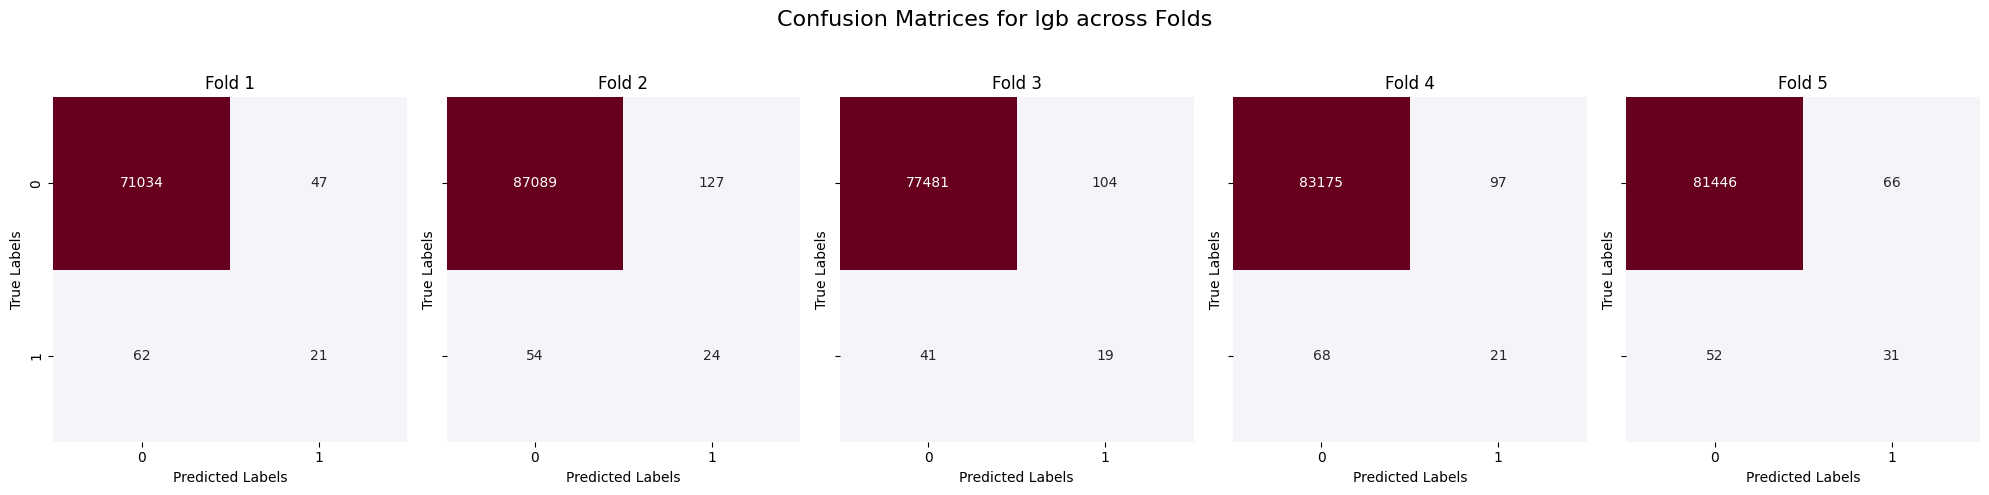

In [54]:
plot_confusion_matrices('lgb', N_SPLITS)

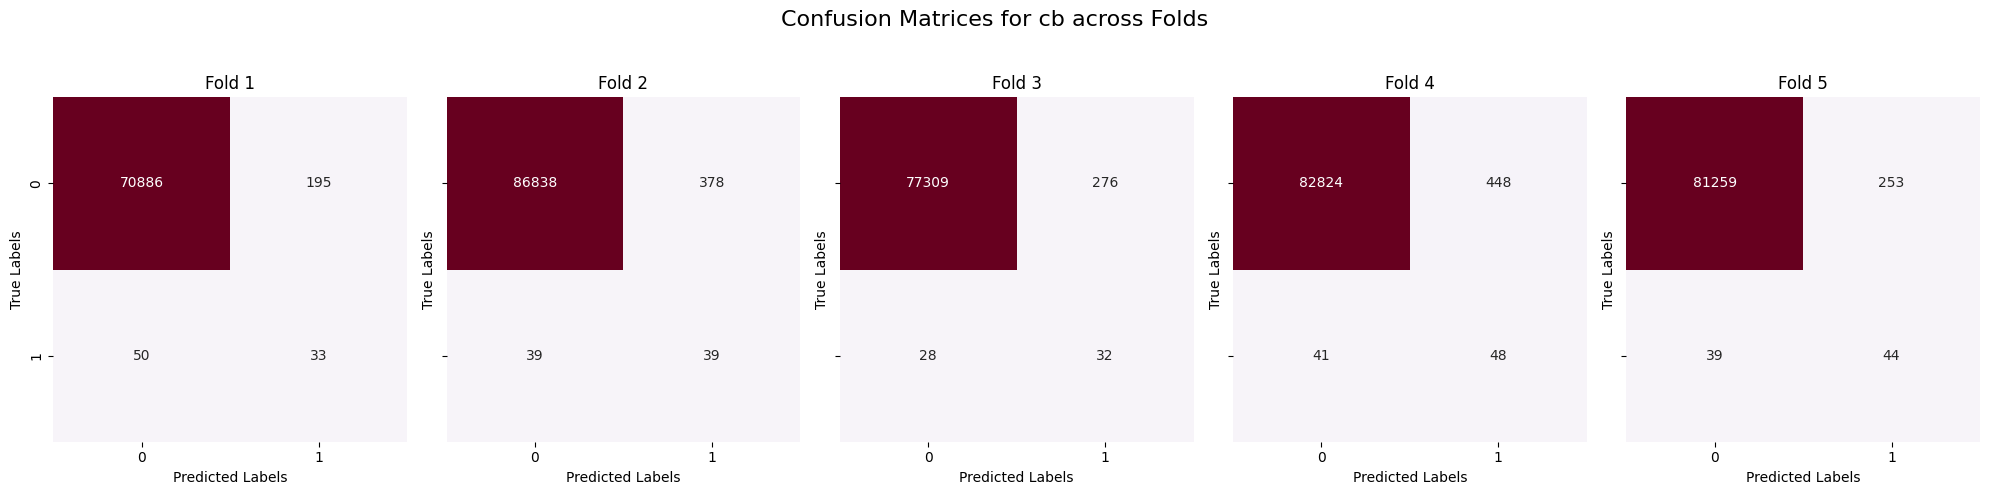

In [55]:
plot_confusion_matrices('cb', N_SPLITS)

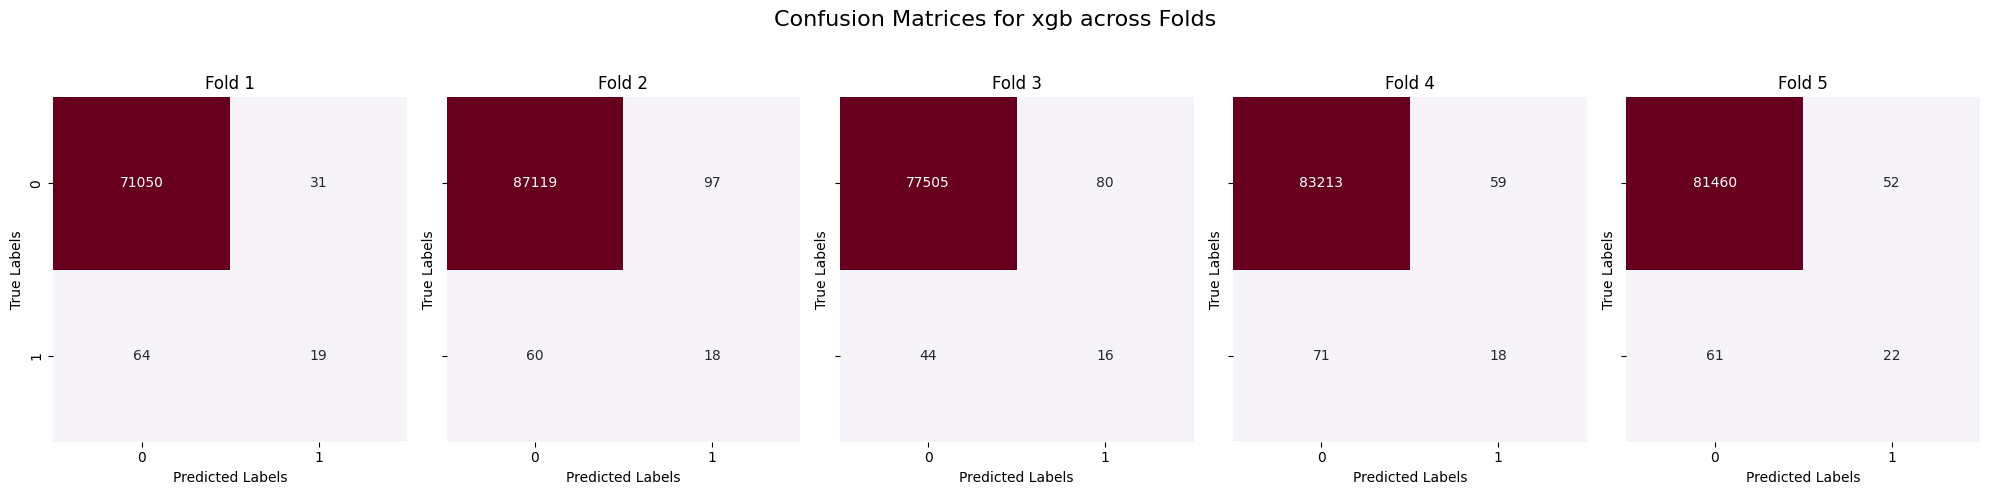

In [56]:
plot_confusion_matrices('xgb', N_SPLITS)

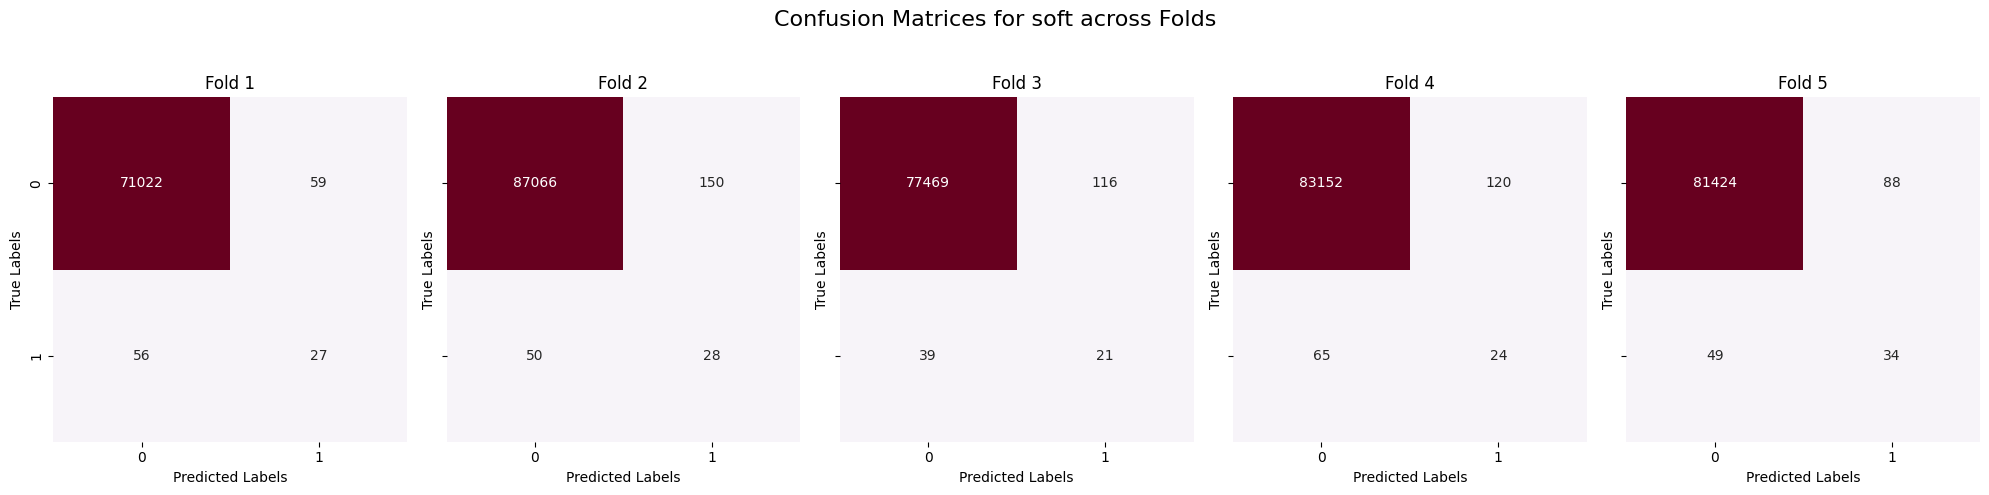

In [57]:
plot_confusion_matrices('soft', N_SPLITS)

#### Partial Area Under the Curve

In [81]:
def plot_pauc_above_tpr(model_name, num_folds, tpr_threshold=0.8):

    fig, axes = plt.subplots(1, num_folds, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f'ROC Curves and pAUC for {model_name} across Folds', fontsize=16)
    
    for fold, (_, val_idx) in enumerate(sgkf.split(X, y, groups)):
        
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]   
        
        model = models[model_name][fold]
        y_proba = model.predict_proba(X_valid)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_valid, y_proba)
        roc_auc = auc(fpr, tpr)
        
        # Filter TPR values to the specified range
        mask = tpr >= tpr_threshold
        tpr_above_threshold = tpr[mask]
        fpr_above_threshold = np.interp(tpr_above_threshold, tpr, fpr)
        
        # Compute pAUC using the trapezoidal rule
        pAUC = np.trapz(tpr_above_threshold, fpr_above_threshold)
        
        ax = axes[fold]
        ax.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        
        ax.axhline(y=tpr_threshold, color='red', linestyle='--', label=f'TPR Threshold = {tpr_threshold*100:.0f}%')
        
        ax.fill_between(fpr_above_threshold, tpr_above_threshold, tpr_threshold, color='orange', alpha=0.3,
                        label=f'pAUC above {tpr_threshold*100:.0f}% TPR = {scores[model_name][fold]:.4f}')
        
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'Fold {fold + 1}: {scores[model_name][fold]:.4f}')
        ax.legend(loc='lower right')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

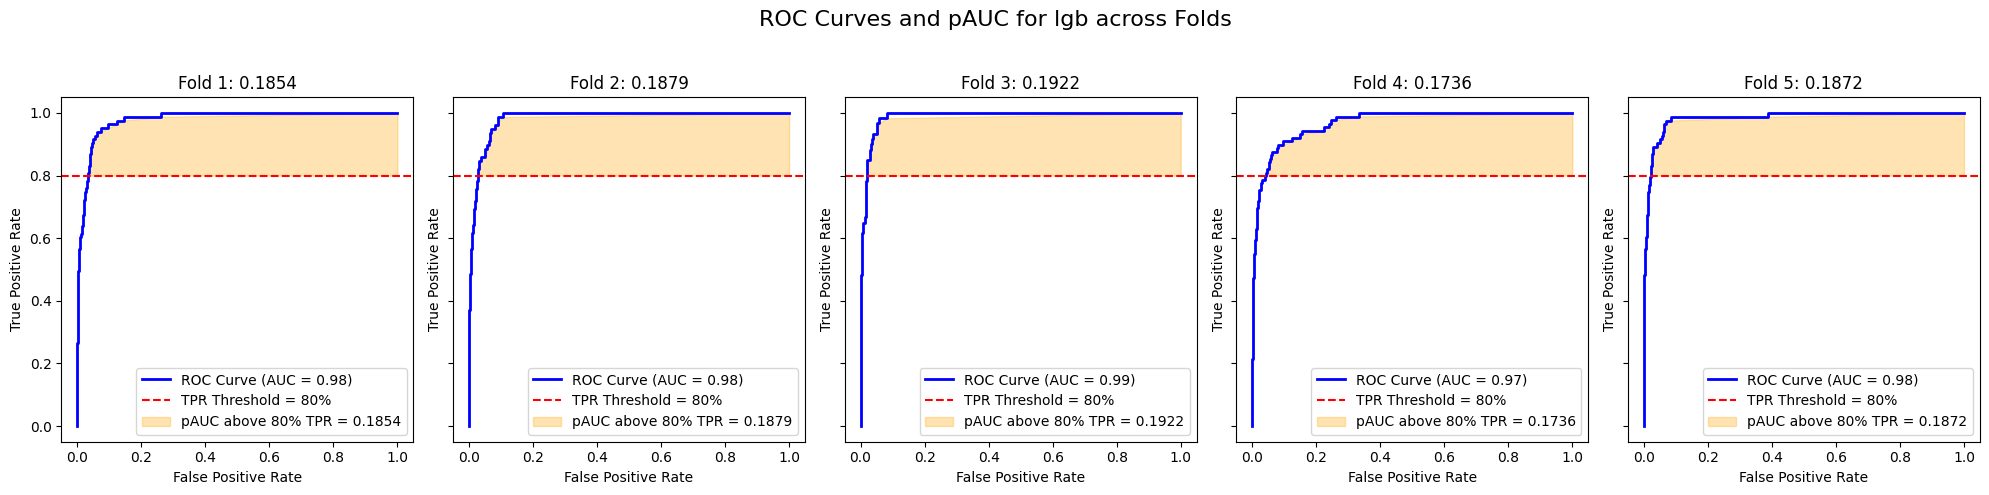

In [82]:
plot_pauc_above_tpr('lgb', N_SPLITS)

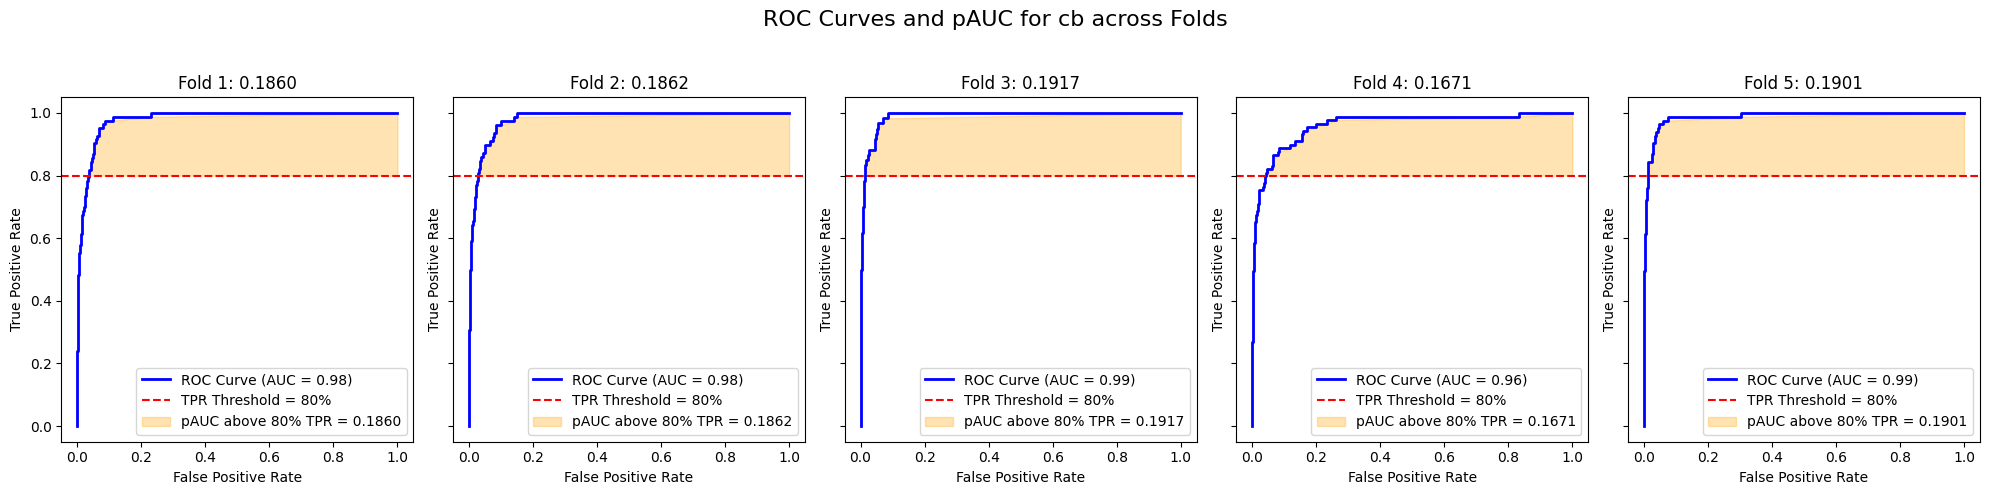

In [83]:
plot_pauc_above_tpr('cb', N_SPLITS)

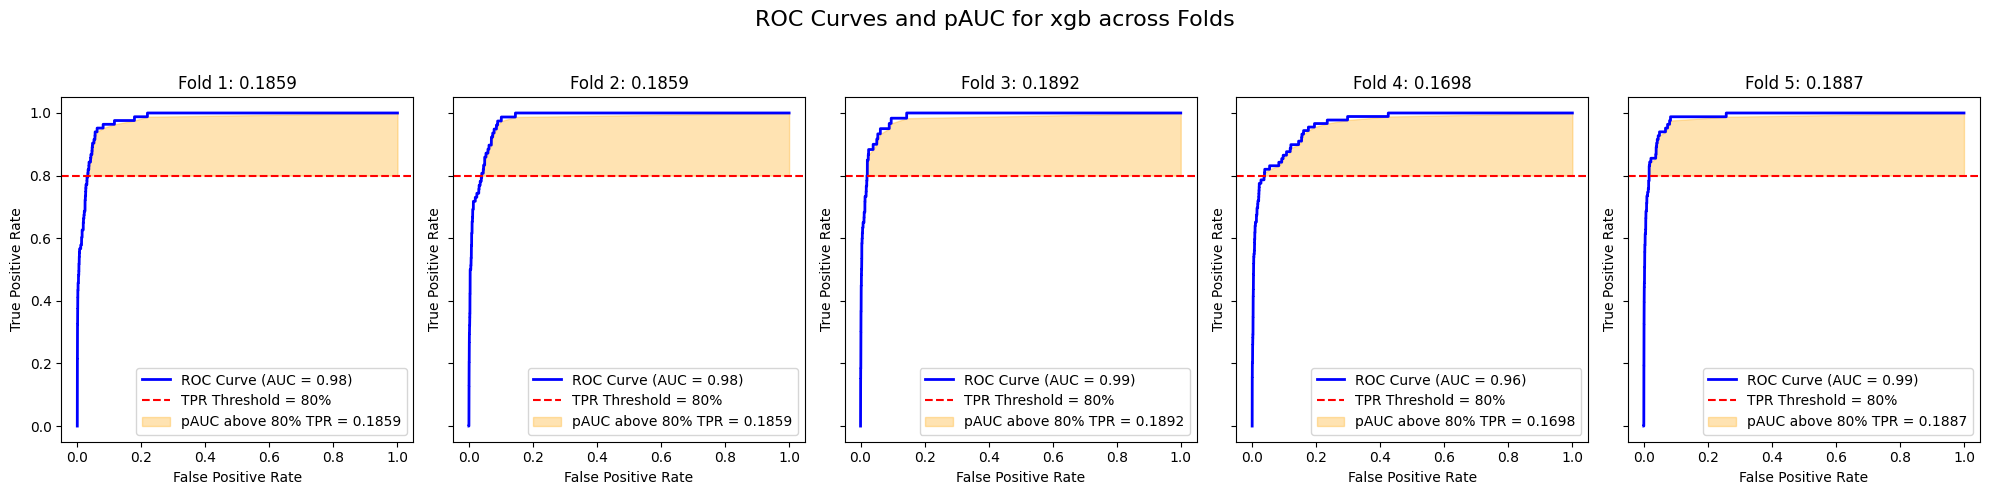

In [84]:
plot_pauc_above_tpr('xgb', N_SPLITS)

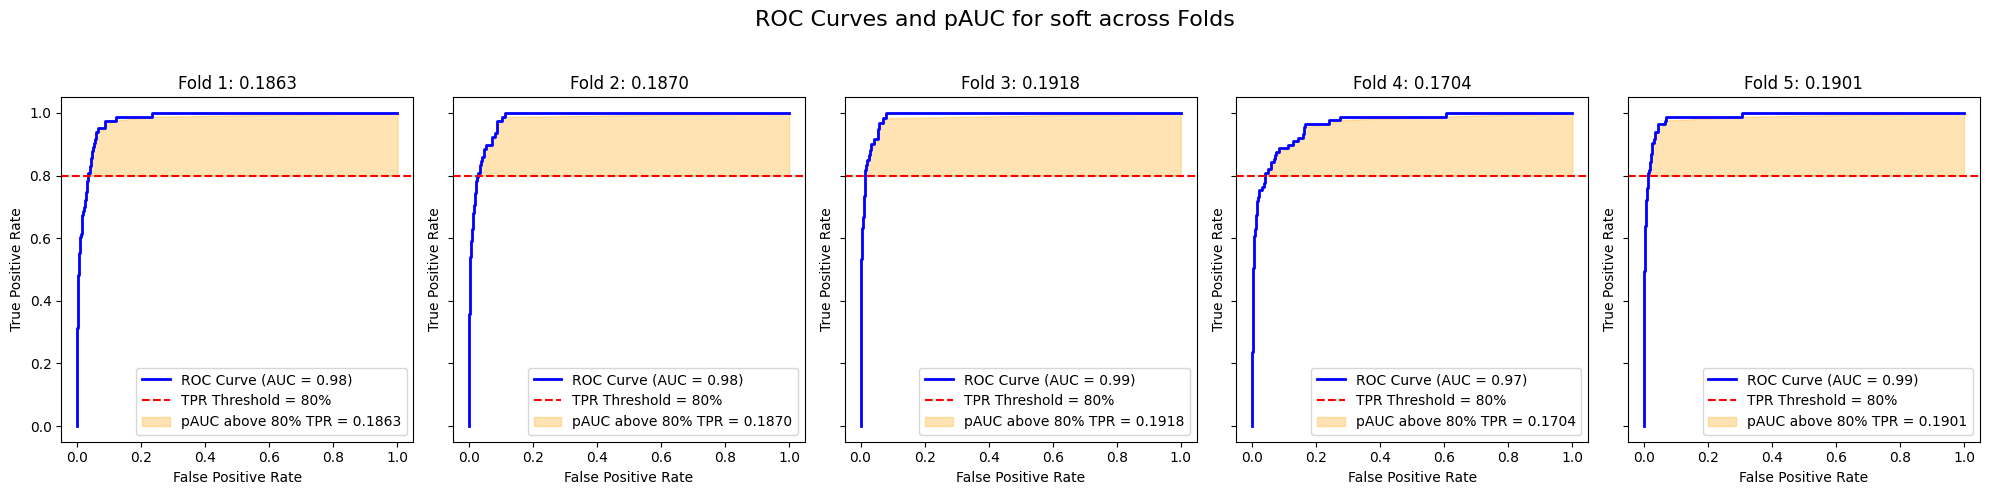

In [85]:
plot_pauc_above_tpr('soft', N_SPLITS)

#### Feature Importance

In [113]:
def plot_avg_feature_importance(model_name, num_folds, top_n=50):

    feature_importances = []
    
    for fold in range(num_folds):

        model = models[model_name][fold]
        
        importances = model.named_steps['classifier'].feature_importances_
        features = X.columns
        feature_importances.append(pd.Series(importances, index=features))
    
    avg_importances = pd.concat(feature_importances, axis=1).mean(axis=1).sort_values(ascending=False).head(50)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=avg_importances.values, y=avg_importances.index, palette='viridis')
    plt.title(f'Average Feature Importance for {model_name}')
    plt.xlabel('Average Importance')
    plt.ylabel('Features')
    plt.show()
    
    top_features = avg_importances.head(top_n)
    
    return top_features.index.tolist()

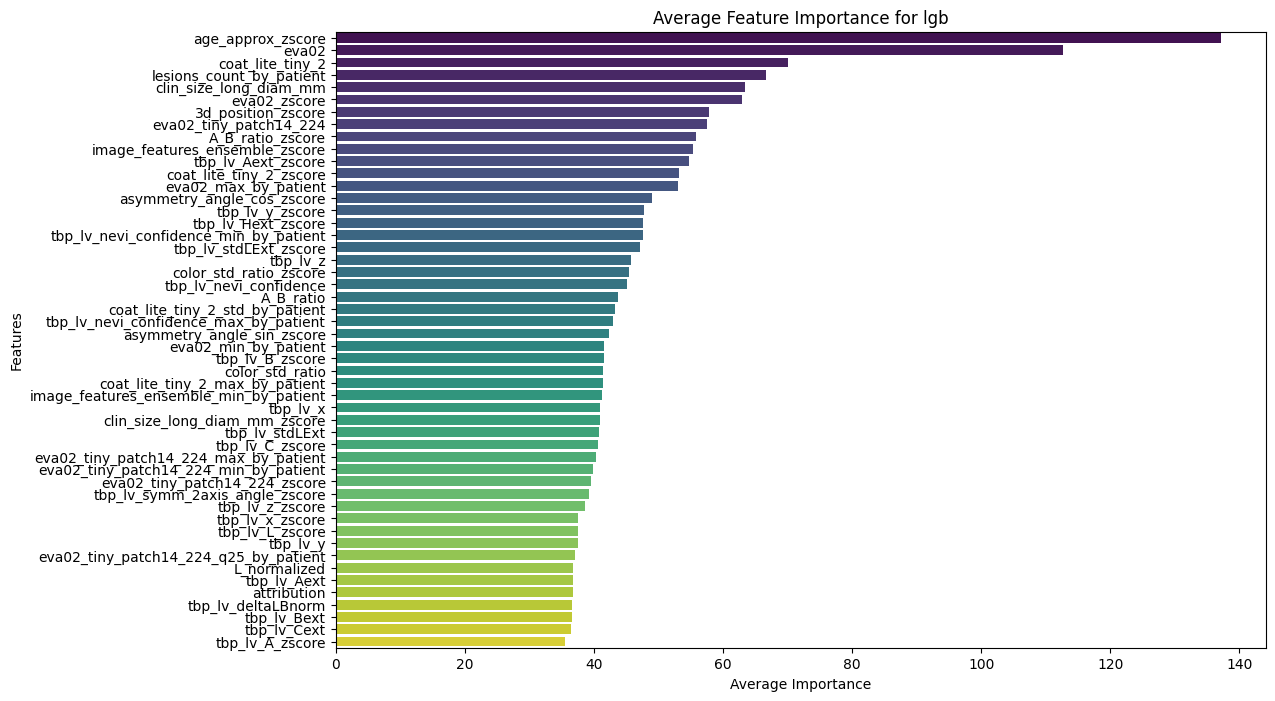

In [114]:
lgb_top_features = plot_avg_feature_importance('lgb', N_SPLITS)

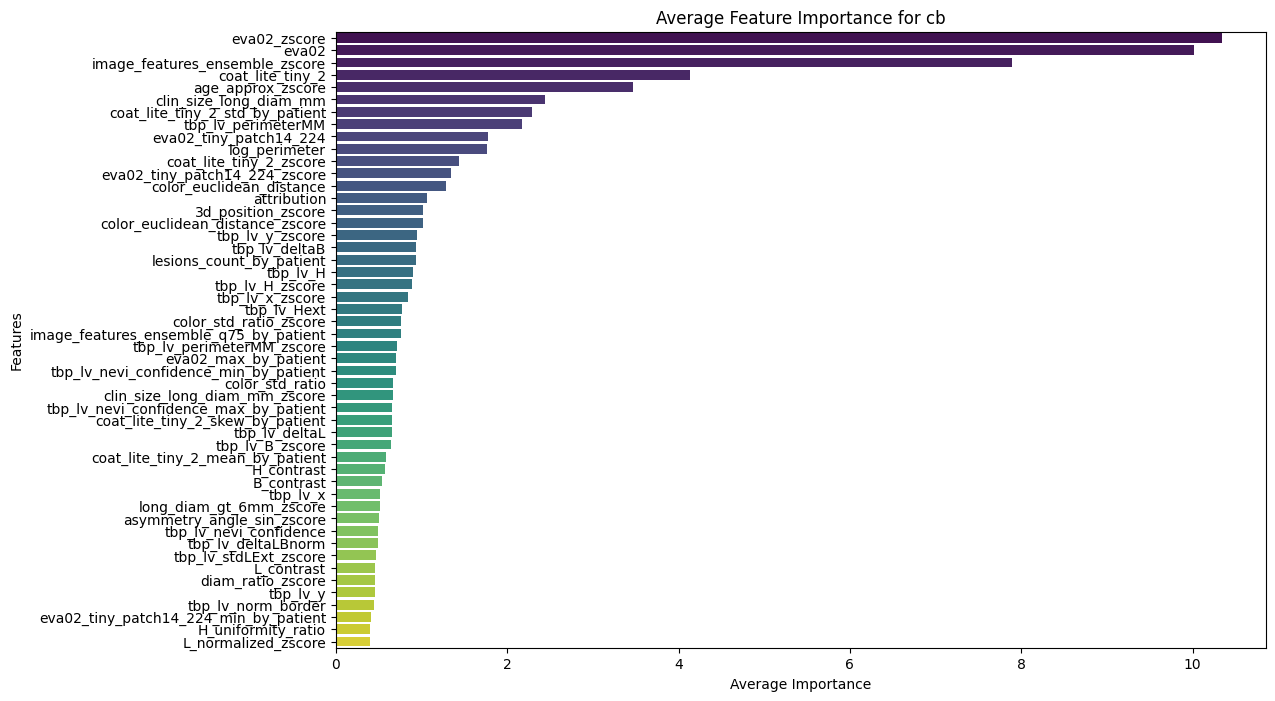

In [115]:
cb_top_features = plot_avg_feature_importance('cb', N_SPLITS)

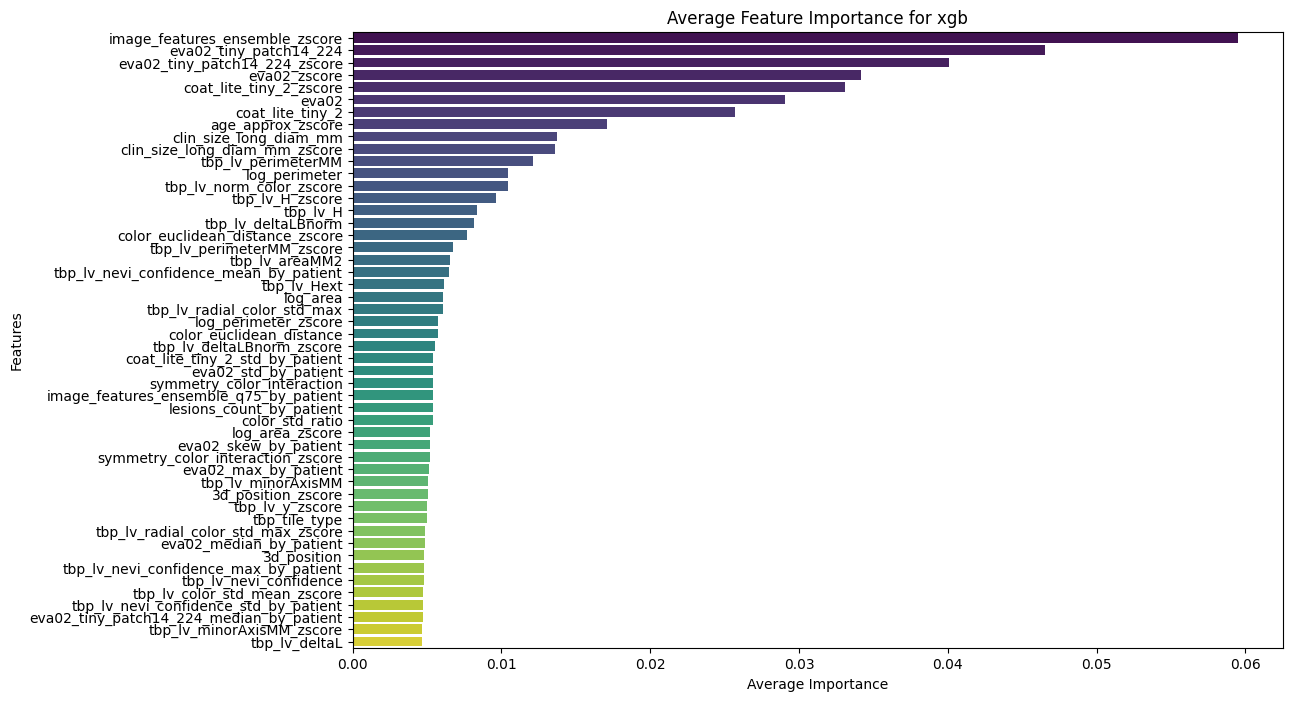

In [116]:
xgb_top_features = plot_avg_feature_importance('xgb', N_SPLITS)

In [117]:
top_features_union = set(lgb_top_features + cb_top_features + xgb_top_features)
print(f'Number of top features union: {len(top_features_union)}') # 92

Number of top features union: 92


In [118]:
top_features_intersection = list(set(lgb_top_features) & set(cb_top_features) & set(xgb_top_features))
print(f'Number of top features intersection: {len(top_features_intersection)}') #19

Number of top features intersection: 19


In [120]:
print(f'Intersection of important features in all 3 models: \n\n {top_features_intersection}')
# ['clin_size_long_diam_mm_zscore', 'eva02_tiny_patch14_224_zscore', 'eva02_max_by_patient', 'eva02_tiny_patch14_224', 'eva02', 'tbp_lv_nevi_confidence', 'coat_lite_tiny_2', 'tbp_lv_nevi_confidence_max_by_patient', 'coat_lite_tiny_2_zscore', 'color_std_ratio', '3d_position_zscore', 'image_features_ensemble_zscore', 'age_approx_zscore', 'eva02_zscore', 'clin_size_long_diam_mm', 'tbp_lv_deltaLBnorm', 'lesions_count_by_patient', 'coat_lite_tiny_2_std_by_patient', 'tbp_lv_y_zscore']

Intersection of important features in all 3 models: 

 ['clin_size_long_diam_mm_zscore', 'eva02_tiny_patch14_224_zscore', 'eva02_max_by_patient', 'eva02_tiny_patch14_224', 'eva02', 'tbp_lv_nevi_confidence', 'coat_lite_tiny_2', 'tbp_lv_nevi_confidence_max_by_patient', 'coat_lite_tiny_2_zscore', 'color_std_ratio', '3d_position_zscore', 'image_features_ensemble_zscore', 'age_approx_zscore', 'eva02_zscore', 'clin_size_long_diam_mm', 'tbp_lv_deltaLBnorm', 'lesions_count_by_patient', 'coat_lite_tiny_2_std_by_patient', 'tbp_lv_y_zscore']


## Feature Selection using ShapRFECV

#### Custom scorer for ShapRFECV

In [135]:
from sklearn.metrics import make_scorer
from probatus.utils import Scorer

def pauc(y_true, y_pred):
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_pred])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

pauc_scorer = Scorer("pauc_metric", custom_scorer=make_scorer(pauc, greater_is_better=True, needs_proba=True))

#### ShapRFECV function

In [144]:
def shap_rfecv(estimator, X, y, groups, cv, scorer, columns_to_keep, min_features=50):
    shap_elimination = ShapRFECV(model=estimator, step=1, cv=cv, scoring=scorer, min_features_to_select=min_features, verbose=0)
    shap_report = shap_elimination.fit_compute(X=X, y=y, groups=groups, columns_to_keep=columns_to_keep, check_additivity=False)
    
    return shap_report

#### LightGBM

In [ ]:
lgb_model = lgb.LGBMClassifier(**lgb_best_params)

start_time = time.time()
lgb_shap_report = shap_rfecv(lgb_model, X, y, groups, sgkf, pauc_scorer, top_features_intersection)
end_time = time.time()
elapsed_seconds = end_time - start_time
print(f"Features Elimination for LightGBM took: {int(elapsed_seconds // 3600)} hours, {int((elapsed_seconds % 3600) // 60)} minutes, {int(elapsed_seconds % 60)} seconds\n")

Found `n_iter` in params. Will use it instead of argument
Found `n_iter` in params. Will use it instead of argument
Found `n_iter` in params. Will use it instead of argument
Found `n_iter` in params. Will use it instead of argument


##### Custom estimator pipeline

In [89]:
class CustomPipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_

In [90]:
lgb_model = CustomPipeline([
    ('classifier', lgb.LGBMClassifier(**lgb_initial_params)),
])

##### Custom scoring metric

In [105]:
from sklearn.feature_selection import RFECV

def rfecv_selection(estimator, X, y, groups, n_features, scorer, cv):
    selector = RFECV(estimator, step=1, min_features_to_select=n_features, cv=cv , scoring=scorer, n_jobs=-1)
    selector = selector.fit(X, y, groups)

    return selector

In [106]:
X = train_metadata[train_cols].values
y = train_metadata[target_col].values
groups = train_metadata[group_col].values

In [107]:
selector = rfecv_selection(estimator=lgb_model, X=X, y=y, groups=groups, n_features=50, scorer=pauc_scorer, cv=sgkf)

In [118]:
features = np.array(train_metadata[train_cols].columns.tolist())
selected_features = features[selector.support_]
selected_features

array(['attribution', 'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
       'roundness_index', 'symmetry_index', 'H_contrast', 'A_B_ratio',
       'L_uniformity', 'A_uniformity', 'H_uniformity_ratio',
       'color_contrast_index', 'clin_size_long_diam_mm_zscore',
       'tbp_lv_Aext_zscore', 'tbp_lv_H_zscore', 'tbp_lv_L_zscore',
       'tbp_lv_deltaB_zscore', 'tbp_lv_minorAxisMM_zscore',
       'tbp_lv_perimeterMM_zscore', 'tbp_lv_radial_color_std_max_zscore',
       'tbp_lv_stdL_zscore

In [122]:
X = train_metadata[train_cols]
y = train_metadata[target_col]
groups = train_metadata[group_col]

lgb_scores = []

lgb_models = []

print(f'Starting Cross-Validation on {N_SPLITS} folds\n')

for fold, (train_idx, valid_idx) in enumerate(sgkf.split(X, y, groups)):

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    lgb_model = Pipeline([
        ('classifier', lgb.LGBMClassifier(**lgb_initial_params)),
    ])

    lgb_model.fit(X_train, y_train)
    lgb_score = pauc_score(lgb_model, X_valid, y_valid)

    lgb_scores.append(lgb_score)

    lgb_models.append(lgb_model)

    print(f'Fold {fold + 1} - LGB: {lgb_score:.4f}\n')

print(f'Average Scores - LGB: {np.mean(lgb_scores):.4f}\n')

Starting Cross-Validation on 5 folds

Fold 1 - LGB: 0.1328

Fold 2 - LGB: 0.1120

Fold 3 - LGB: 0.1343

Fold 4 - LGB: 0.1005

Fold 5 - LGB: 0.1429

Average Scores - LGB: 0.1245



In [437]:
def plot_permutation_importance(models, model_name, feature_names, splits, X, y):

    weights = []

    for fold, (_, valid_idx) in enumerate(splits):
        X_valid = X.iloc[valid_idx]
        y_valid = y.iloc[valid_idx]

        perm = PermutationImportance(models[fold], random_state=SEED, scoring=pauc_score).fit(X_valid, y_valid)
        fold_weights = eli5.explain_weights_df(perm, feature_names=feature_names)
        weights.append(fold_weights)

        avg_weights = pd.concat(weights).groupby('feature')['weight'].mean().reset_index()
    
    plt.figure(figsize=(16, 12))
    sns.barplot(data=avg_weights.sort_values(by='weight', ascending=False).head(100), x='weight', y='feature')
    plt.title(f'{model_name} Permutation Importance')
    plt.tight_layout()
    plt.show()

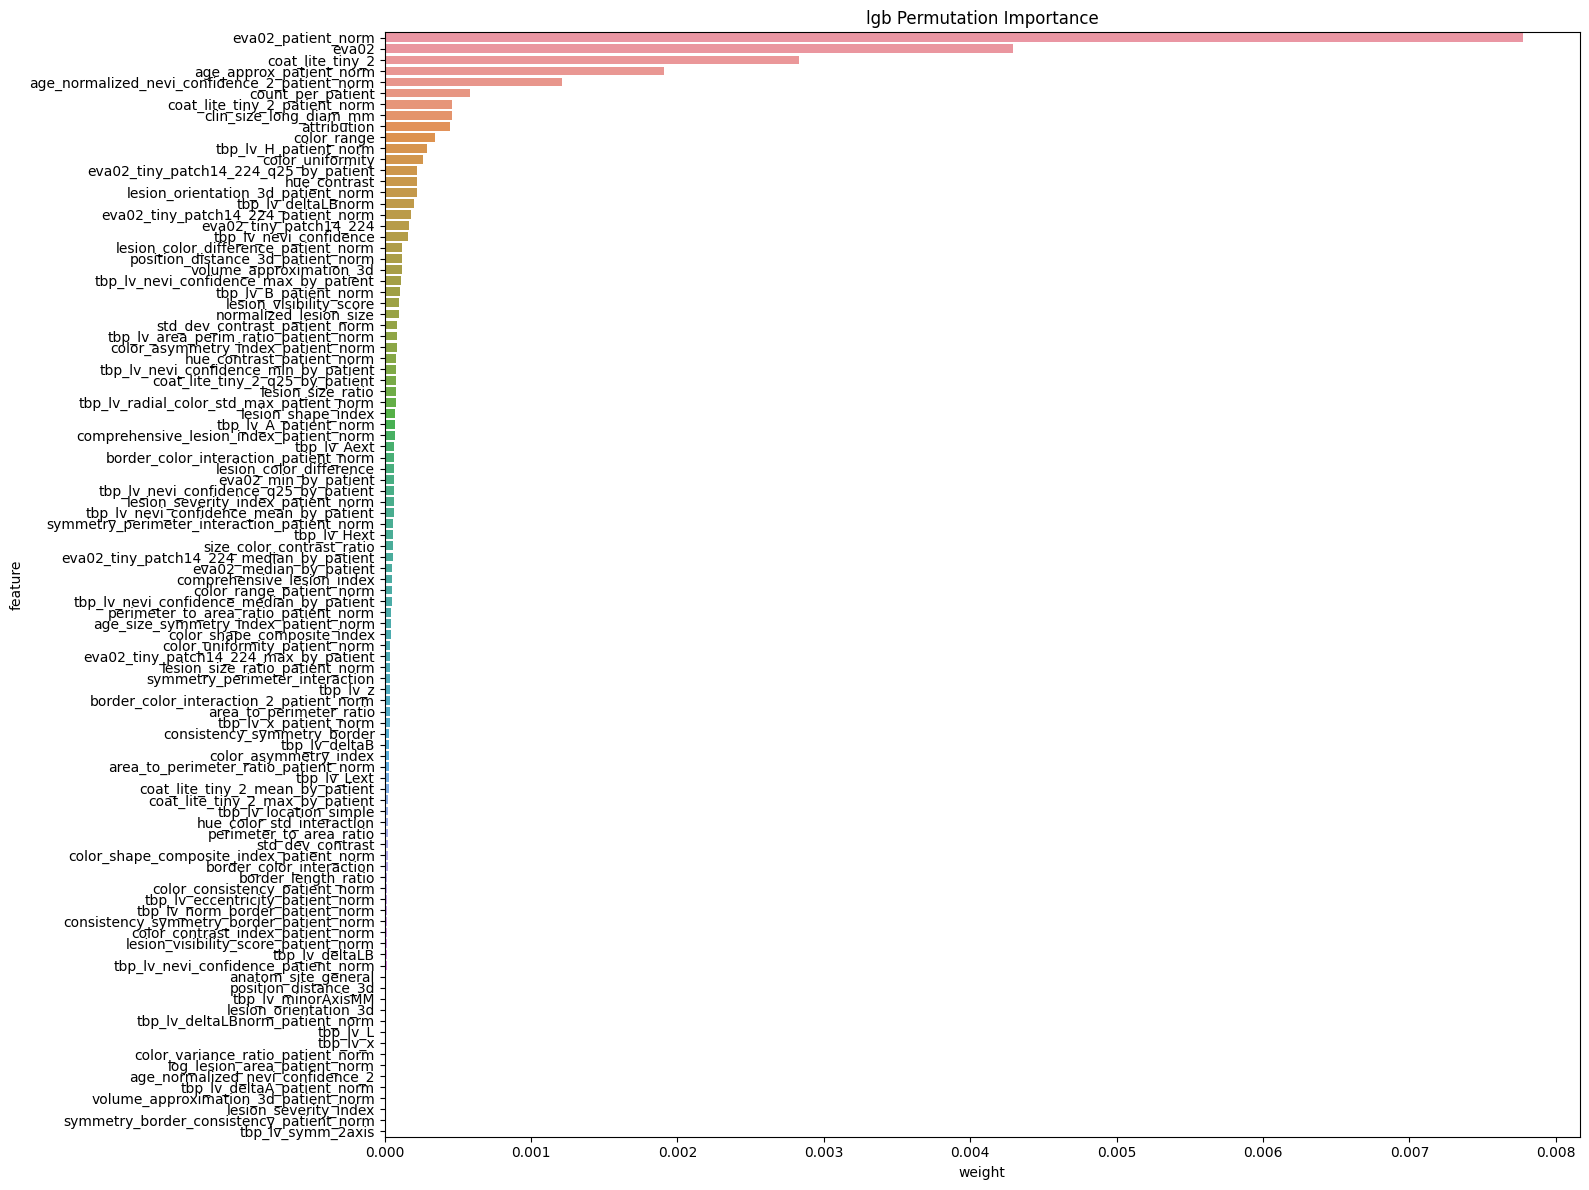

In [439]:
plot_permutation_importance(models['lgb'], 'lgb', train_cols, sgkf.split(X, y, groups), X, y)